In [11]:
!wget https://github.com/wkwbk/ipynb/raw/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data1.csv
!wget https://github.com/wkwbk/ipynb/raw/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data2.csv
!wget https://github.com/wkwbk/ipynb/raw/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data3.csv
!wget https://github.com/wkwbk/ipynb/raw/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf

--2025-04-07 13:13:36--  https://github.com/wkwbk/ipynb/raw/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data1.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wkwbk/ipynb/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data1.csv [following]
--2025-04-07 13:13:36--  https://raw.githubusercontent.com/wkwbk/ipynb/refs/heads/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/data1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18063731 (17M) [text/plain]
Saving to: ‘data1.csv’

data1.csv           100%[===================>]  17.23M  --.-KB/s    in 0.1s    

2025-04-07 13:13:37 (137 MB/s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185725 entries, 0 to 185724
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   时间        185725 non-null  object 
 1   GPS车速     185725 non-null  float64
 2   X轴加速度     185725 non-null  float64
 3   Y轴加速度     185725 non-null  float64
 4   Z轴加速度     185725 non-null  float64
 5   经度        185725 non-null  float64
 6   纬度        185725 non-null  float64
 7   发动机转速     185725 non-null  int64  
 8   扭矩百分比     185725 non-null  int64  
 9   瞬时油耗      185725 non-null  float64
 10  油门踏板开度    185725 non-null  float64
 11  空燃比       185725 non-null  float64
 12  发动机负荷百分比  185725 non-null  int64  
 13  进气流量      185725 non-null  float64
dtypes: float64(10), int64(3), object(1)
memory usage: 19.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145825 entries, 0 to 145824
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   --

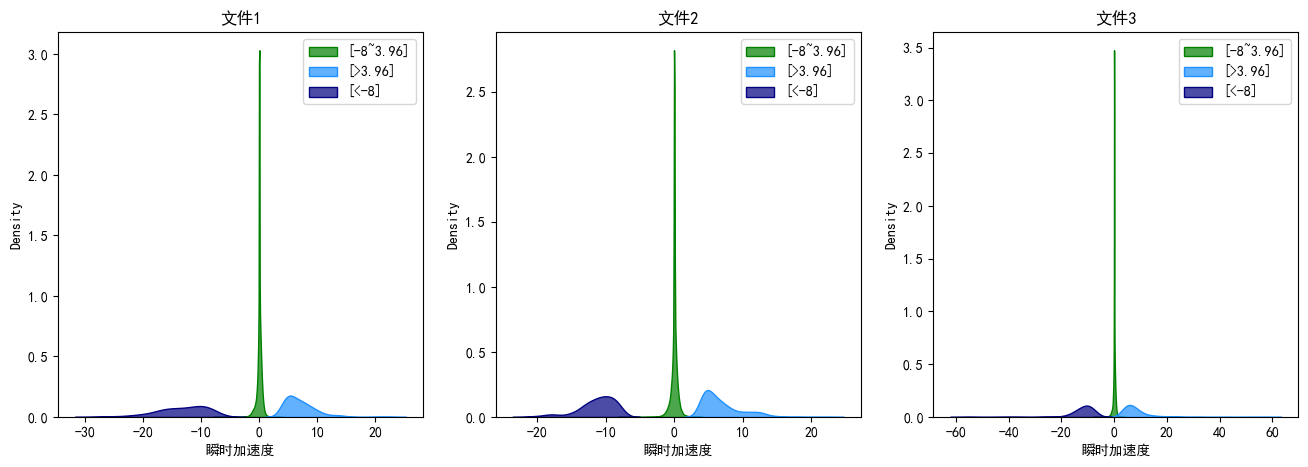

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime
import seaborn as sns

fm.fontManager.addfont('./SimHei.ttf')
plt.rcParams['font.sans-serif'] = ['SimHei']

data_1=pd.read_csv("./data1.csv")
data_2=pd.read_csv("./data2.csv")
data_3=pd.read_csv("./data3.csv")

data_1.info()
data_2.info()
data_3.info()

def str2DateTime(data):
    for x in data:
        x["时间"]=pd.to_datetime(x["时间"],format="%Y/%m/%d %H:%M:%S.000.")

str2DateTime([data_1,data_2,data_3])

time1=data_1["时间"].diff().dt.total_seconds()
time2=data_2["时间"].diff().dt.total_seconds()
time3=data_3["时间"].diff().dt.total_seconds()
def interpolate(x,y,n):
    res=[]
    delta=(y-x)/n
    for i in range(1,n):
        res.append(x+delta)
        x=x+delta
    return res

def filling_values(data_1):
    wait_add_dfs = []
    time1=data_1["时间"].diff().dt.total_seconds()

    for row_index,item in data_1.loc[(time1<=10) & (time1>=2),:].iterrows():
        n=int(time1[row_index])
        delta_df=pd.DataFrame()
        row=data_1.iloc[row_index-1,:]
        delta_df["时间"]=[row["时间"]+datetime.timedelta(seconds=i) for i in range(1,n)]
        for _f in data_1.columns:
            if _f == 'X轴加速度' or _f == 'Y轴加速度' or _f == 'Z轴加速度':
                delta_df[_f]=[(item[_f]+row[_f])/2 for x in range(1,n)]
                continue
            delta_df[_f]=interpolate(row[_f], item[_f],n)
        wait_add_dfs.append(delta_df)
    if wait_add_dfs:
        wait_add_df = pd.concat(wait_add_dfs, ignore_index=True)
    else:
        wait_add_df = pd.DataFrame()

    data_tmp=pd.concat([data_1,wait_add_df],ignore_index=True)
    data_tmp.sort_values(by=["时间"],inplace=True)
    data_tmp=data_tmp.reindex(range(len(data_tmp)))
    return data_tmp


data_1=filling_values(data_1)
data_2=filling_values(data_2)
data_3=filling_values(data_3)

def deleteMoreTen(data):
    tmp=data["时间"].diff().dt.total_seconds()
    data.loc[tmp>10,:]=np.nan
    data.dropna(inplace=True)
    data=data.reindex(range(len(data)))
    return data

data_1=deleteMoreTen(data_1)
data_2=deleteMoreTen(data_2)
data_3=deleteMoreTen(data_3)

def del_index(data):
    list_a=[]
    for df1 in data:
        df1["瞬时加速度"]=round((df1["GPS车速"].diff().shift(-1)*(5/18)),4)
        list_a.append(df1["瞬时加速度"].to_list())
        count1=0
        count2=0
        for (index,sw) in df1.iterrows():
            if index==df1.shape[0]-1:
                if df1["时间"][index]!=df1["时间"][index-1]+datetime.timedelta(seconds=1):
                    df1["时间"][index]=np.nan
                count1+=1
            if df1["时间"][index]!=np.nan:
                count1+=1
            if df1["瞬时加速度"][index]<-8 or df1["瞬时加速度"][index]>3.968:
                df1["瞬时加速度"][index]=np.nan
                count2+=1
    return list_a

def paint_jsd(data_1,data_2,data_3):
    plt.rcParams['axes.unicode_minus']=False
    fig=plt.figure(figsize=(16,5), dpi=100)
    grid=plt.GridSpec(1,3)
    ax_left=plt.subplot(grid[0,0])
    ax_main=plt.subplot(grid[0,1])
    ax_right=plt.subplot(grid[0,2])
    x_title=["文件1","文件2","文件3"]


    dataframes = [data_1, data_2, data_3]

    for i,ax in enumerate([ax_left,ax_main,ax_right]):

        # 计算瞬时加速度（如果尚未计算）
        dataframes[i]["瞬时加速度"]=round((dataframes[i]["GPS车速"].diff().shift(-1)*(5/18)),4)

        # 绘制密度图，同时过滤加速度值
        sns.kdeplot(dataframes[i].loc[ (dataframes[i]["瞬时加速度"]<3.96) & (dataframes[i]["瞬时加速度"]>=-8)]["瞬时加速度"],fill=True,color="g",label="[-8~3.96]",alpha=.7,ax=ax)
        sns.kdeplot(dataframes[i].loc[ (dataframes[i]["瞬时加速度"]>3.96)]["瞬时加速度"],fill=True,color="dodgerblue",label="[>3.96]",alpha=.7,ax=ax)
        sns.kdeplot(dataframes[i].loc[ (dataframes[i]["瞬时加速度"]<-8)]["瞬时加速度"],fill=True,color="#000080",label="[<-8]",alpha=.7,ax=ax)

        ax.set_title(x_title[i])
        ax.legend()

    plt.savefig("加速度密度分析图.png")
    plt.show()

data_1=data_1.dropna()
data_2=data_2.dropna()
data_3=data_3.dropna()

data_1=data_1.reset_index(drop=True)
data_2=data_2.reset_index(drop=True)
data_3=data_3.reset_index(drop=True)

def del_idle_speed_records(data):
    data = data.reset_index(drop=True)
    idle_time=data[data["GPS车速"]==0]
    time_windows=10
    _i=0
    begin_flag=False
    head_index=0
    head_i=0
    flag=False
    first_index=0
    last_index=0
    index_res=[]

    for _, row in data.iterrows():
        if row['GPS车速']==0:
            if not flag:
                flag=True
                first_index_=_
            else:
                if flag:
                    last_index_=_
                    flag=False
                    index_res.append((first_index,last_index))
        _sum=0
        for (a,b) in index_res:
            if b-a>180:
                _sum+=1
                drop_index=[]
                i=0
                while a+180+i<b:
                    drop_index.append(a+180+i)
                    i+=1
                #print(data.shape)
                data.drop(drop_index,inplace=True)
                #print(data.shape)

        print(_sum,len(index_res))
        print('after del idle time:',data.shape[0])
        data.index=range(len(data))
        return data

data_1=del_idle_speed_records(data_1)
data_2=del_idle_speed_records(data_2)
data_3=del_idle_speed_records(data_3)

# 调用加速密度图函数
paint_jsd(data_1,data_2,data_3)

data_1.to_csv("./删除速度异常文件1.csv")
data_2.to_csv("./删除速度异常文件2.csv")
data_3.to_csv("./删除速度异常文件3.csv")
